In [1]:
# Author: James Meehan
# Date: 8/15/2018
# Description: Machine learning model to predict Week 1 2018 fantasy scores for tight ends 

# import libraries
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
from sklearn import preprocessing

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# pull in data, separate into data stack, labels, and actual scores
df = pd.read_csv('TEstack2018.csv', sep=',', )
pts_targets = df
labels = df

labels = labels.loc[0:, 'fname':'actual']
labels = labels.values

df = df.loc[0:, 'rating':'retd_2wk']
pts_targets = pts_targets.loc[0:, 'actual']

df = df.values
df.shape

(1180, 18)

In [5]:
# normalize the inputs
scaled_inputs = preprocessing.scale(df)
print(scaled_inputs)

samples_count = scaled_inputs.shape[0]

# split into training and test groups (80% training / 20% test)
train_samples = int(0.8*samples_count)
test_samples = int(samples_count - train_samples)

train_inputs = scaled_inputs[:train_samples]
train_targets = pts_targets[:train_samples]

test_inputs = scaled_inputs[train_samples:]
test_targets = pts_targets[train_samples:]

[[-1.10155719 -1.01365251 -1.13835997 ... -0.23591734 -0.45800854
  -0.54693676]
 [-0.41271909 -1.01365251 -1.25445095 ... -0.23591734 -0.35759047
   1.33465327]
 [-1.23932481 -1.01365251 -0.18060943 ...  1.15483602  0.04408183
  -0.54693676]
 ...
 [ 0.276119    0.98653137  0.89323208 ... -1.16308625 -1.22788045
   1.33465327]
 [ 1.92933042  0.98653137  0.22570898 ...  0.69125156  0.04408183
  -0.54693676]
 [ 2.48040089  0.98653137  0.48691367 ... -1.16308625 -1.12746238
  -0.54693676]]


In [6]:
print("Training set: {}".format(train_inputs.shape))  # 944 examples, 18 features
print("Testing set:  {}".format(test_inputs.shape))   # 236 examples, 18 features

Training set: (944, 18)
Testing set:  (236, 18)


In [7]:
# build the neural network. 1 hiddne layer with 35 neurons.
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(35, activation=tf.nn.relu, 
                       input_shape=(train_inputs.shape[1],)),
   #keras.layers.Dense(40, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])
  #AdamOptimizer
  optimizer = tf.train.AdamOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 35)                665       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 36        
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

# Store training stats
history = model.fit(train_inputs, train_targets, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................

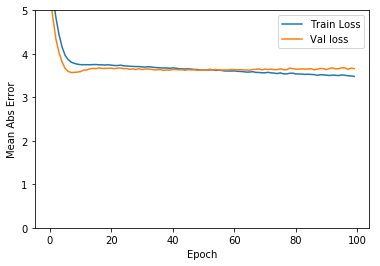

In [10]:
# graph training
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,5])

plot_history(history)

In [11]:
# calculate performance
[loss, mae] = model.evaluate(test_inputs[:-10], test_targets[:-10], verbose=0)

print("Testing set Mean Abs Error: {:7.2f}".format(mae))
print("Testing set Mean Squared Error: {:7.2f}".format(loss))

Testing set Mean Abs Error:    3.49
Testing set Mean Squared Error:   18.41


In [12]:
# get predictions
test_predictions = model.predict(test_inputs).flatten()

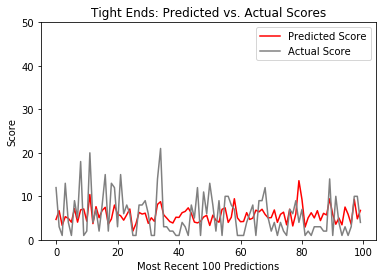

In [13]:
# graph predicted vs. actual scores
def plot_predict():
  plt.figure()
  plt.title('Tight Ends: Predicted vs. Actual Scores')
  plt.xlabel('Most Recent 100 Predictions')
  plt.ylabel('Score')
  plt.plot(np.array(test_predictions[110:210]), label = "Predicted Score", color="red")
  plt.plot(np.array(test_targets[110:210]), label = "Actual Score", color="grey")
  plt.legend()
  plt.ylim([0,50])

plot_predict()

In [14]:
# get 2018 predictions
predict2018 = test_predictions[-10:]
TEtest_labels = labels[-10:]

fullList = []

for i in range(0, len(predict2018)):
    mylist = []
    mylist.append(TEtest_labels[i][0])
    mylist.append(TEtest_labels[i][1])
    mylist.append(int(TEtest_labels[i][2]))
    mylist.append(int(TEtest_labels[i][3]))
    mylist.append(0)
    mylist.append(predict2018[i])
    fullList.append(mylist)
print (fullList)

[['Rob ', 'Gronkowski', 1, 2018, 0, 9.187991], ['Travis', 'Kelce', 1, 2018, 0, 7.404522], ['Zach', 'Ertz', 1, 2018, 0, 5.07658], ['Greg', 'Olsen', 1, 2018, 0, 5.522263], ['Evan', 'Engram', 1, 2018, 0, 6.210526], ['Delanie', 'Walker', 1, 2018, 0, 6.7991834], ['Jordan', 'Reed', 1, 2018, 0, 3.3746274], ['Jimmy', 'Graham', 1, 2018, 0, 6.428701], ['Jack', 'Doyle', 1, 2018, 0, 6.9027343], ['Kyle', 'Rudolph', 1, 2018, 0, 9.2230425]]


In [15]:
# place predictions in a csv for easy placement into the database
import csv
from pandas import read_csv 

with open("TE2018Output.csv","w",newline="") as newFile: 
    cw = csv.writer(newFile, delimiter=',')
    for i in fullList:
        cw.writerow(i)
        
TEformat = read_csv('TE2018Output.csv', sep=',', names=['fname', 'lname', 'week', 'yr', 'actual', 'predicted'])       
TEformat.to_csv('TE2018Output.csv', index=False)

In [16]:
# set up database connection
import psycopg2
conn = psycopg2.connect(database="Cepheus_db",
                        user="db_usr",
                        password="B3av3rs1!",
                        host="osucepheus.cgwruhobay1w.us-east-2.rds.amazonaws.com",
                        port="5432")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [17]:
#Create cursor with which to execute queries
cur = conn.cursor()

In [18]:
#parse csv
with open ('TE2018Output.csv') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        #build query string
        query1 = 'INSERT INTO te_results(fname, lname, week, yr, actual, predicted) VALUES '
        query2 =row['fname'], row['lname'], row['week'], row['yr'], row['actual'], row['predicted']
        query = str(query1) + str(query2)
        print(query)
        #execute query
        cur.execute(query)
#commit change
conn.commit()

INSERT INTO te_results(fname, lname, week, yr, actual, predicted) VALUES ('Rob ', 'Gronkowski', '1', '2018', '0', '9.187991')
INSERT INTO te_results(fname, lname, week, yr, actual, predicted) VALUES ('Travis', 'Kelce', '1', '2018', '0', '7.404522')
INSERT INTO te_results(fname, lname, week, yr, actual, predicted) VALUES ('Zach', 'Ertz', '1', '2018', '0', '5.07658')
INSERT INTO te_results(fname, lname, week, yr, actual, predicted) VALUES ('Greg', 'Olsen', '1', '2018', '0', '5.522263')
INSERT INTO te_results(fname, lname, week, yr, actual, predicted) VALUES ('Evan', 'Engram', '1', '2018', '0', '6.210526')
INSERT INTO te_results(fname, lname, week, yr, actual, predicted) VALUES ('Delanie', 'Walker', '1', '2018', '0', '6.7991834')
INSERT INTO te_results(fname, lname, week, yr, actual, predicted) VALUES ('Jordan', 'Reed', '1', '2018', '0', '3.3746273999999996')
INSERT INTO te_results(fname, lname, week, yr, actual, predicted) VALUES ('Jimmy', 'Graham', '1', '2018', '0', '6.428701')
INSERT I